# Практика

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.stats.weightstats as ssw
import math
%matplotlib inline

## ЦПТ для различных распределений
Возьмите то непрерывное распределение, которое вам больше всего понравится из списка доступных в модуле [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

### Сгенерируйте примеры из распределения

In [2]:
# ваш код тут

# например вот такое распределение https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cosine.html#scipy.stats.cosine
# rv = sts.cosine()

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2
df = 30
rv = sts.chi2(df)

sample = rv.rvs(100) # random variates
sample[0:25]

array([20.71673224, 46.75426964, 33.24420617, 33.13558079, 29.36522905,
       24.83334748, 25.24885941, 34.79032946, 31.84501627, 22.91987094,
       19.03613987, 33.43416815, 20.68364752, 24.1803235 , 20.77708487,
       26.65692107, 27.01194471, 36.82046067, 36.85437774, 21.93813392,
       40.89419586, 27.6948274 , 21.16150069, 37.78247484, 37.14627817])

In [3]:
sample.dtype

dtype('float64')

In [4]:
real_mean = rv.mean() # настоящее среднее случайной величины
real_mean

30.0

In [5]:
real_var = rv.var() # настоящая дисперсия случайной величины
real_var

60.0

### Постройте гистограмму выборки и теоретическую плотность распределения

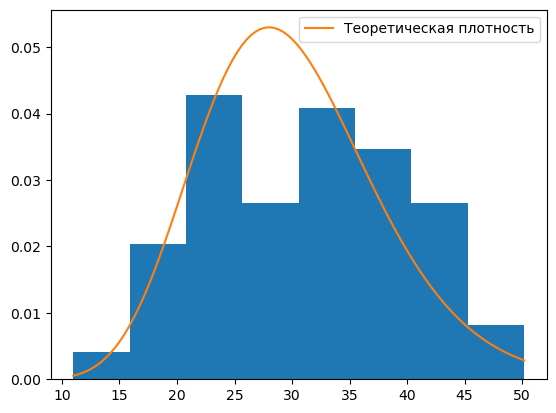

In [6]:
# ваш код тут

plt.hist(sample, density=True, bins='auto')
x = np.linspace(sample.min(), sample.max(), 100)
pdf = rv.pdf(x) # probability density function
plt.plot(x, pdf, label='Теоретическая плотность')
plt.legend()

plt.show()

In [7]:
sample_mean = sample.mean() # выборочное среднее
sample_var = sample.var() # выборочная дисперсия

print(f'mean={sample_mean}, var={sample_var}')

mean=31.059939906188944, var=70.81793222181138


### Оценим распределение выборочного среднего для разных объёмов выборок
Для этого постройте на одном полотне гистограмму выборочных средних и теоретическое распределение выборочных средних по ЦПТ для разных объёмов выборок.

Для теоретического распределение используйте настоящие значения мат ожидания и дисперсии (не приближенные на основе выборки).

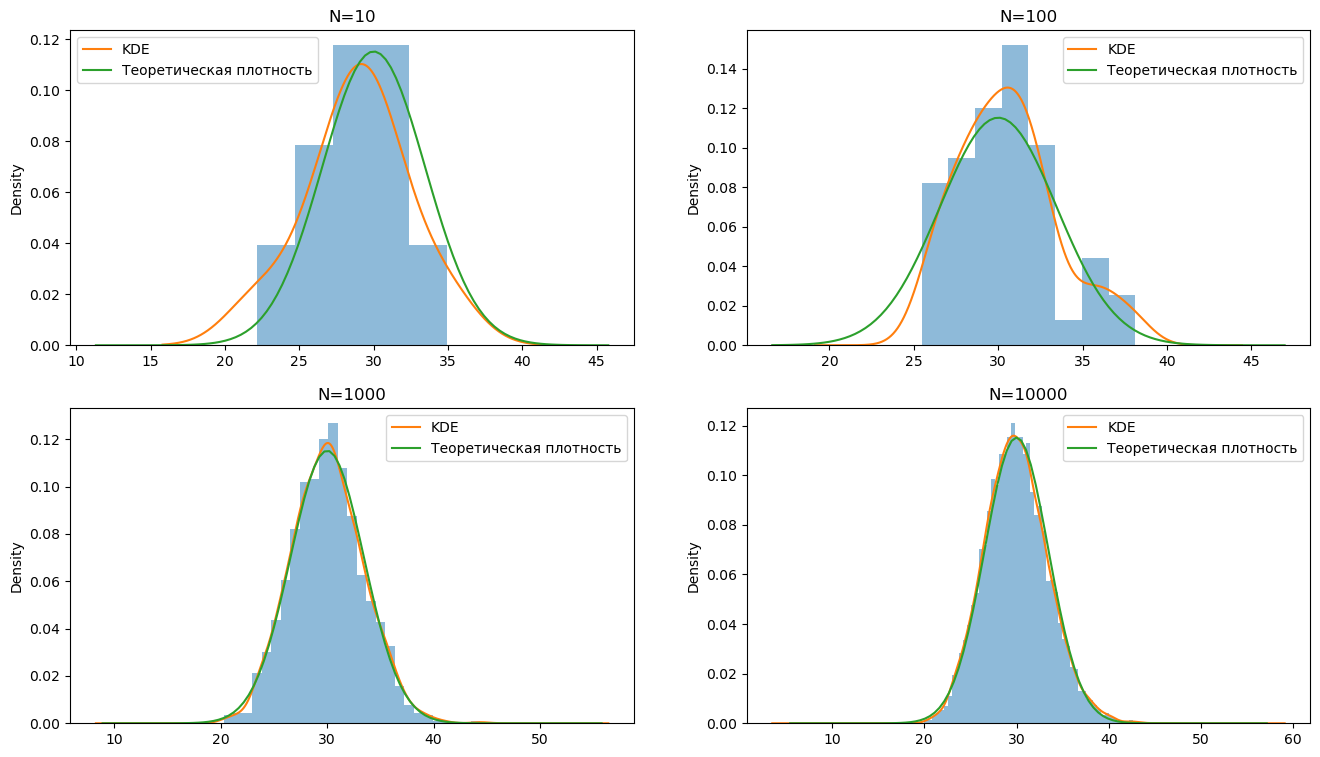

In [8]:
# ваш код тут

n_rows = 2
n_cols = 2

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(16, 9)

def plot_sample(rv, n, N, ax):
    ax.set_title(f'N={N}')

    # Генерируем выборочне средние
    means = []
    
    for i in range(N):
        means.append(np.mean(rv.rvs(n)))

    means = np.array(means).astype(np.float32)
    
    _var = means.var()
    _min = means.min() - _var
    _max = means.max() + _var

    # Строим гистограмму выборочных средних
    ax.hist(means, density=True, bins='auto', alpha=0.5)
    #ax.hist(means, density=True, bins=16, alpha=0.5)

    # Строим KDE
    df = pd.DataFrame(means, columns=['KDE'])
    df.plot(kind='density', ax=ax)

    # Строим теоретическое распределение выборочных средних
    norm_rv = sts.norm(loc=rv.mean(), scale=rv.std()/np.sqrt(n))
    x = np.linspace(_min, _max, 100)
    pdf = norm_rv.pdf(x)
    ax.plot(x, pdf, label='Теоретическая плотность')

    ax.legend()

# Строим графики для разных объёмов выборок
n = 5
power = 1
N = [10, 100, 1000, 10000]
for i in range(n_rows):
    for j in range(n_cols):
        _n = N[i*n_cols+j]
        plot_sample(rv, n, _n, ax[i][j])

Как вы считаете, для выбранного распределения апроксимация распределения выборочного среднего работает хорошо или плохо?
**Ваш ответ:**

**Ответ:**

Думаю, что при очень большом количестве выборочных средних апроксимация распределения выборочного среднего стремится к теоретическому значению распределения. При значени $N=10000$ распределения практически совпадают.

## Доверительный интервал на основе ЦПТ
Возьмите данные для оттока телеком компании, и постройте доверительные интервалы для среднего значения total day calls, используя центральную предельную теорему в разбиении по колонке churn (ушел/не ушел). 

Для оценки дисперсии используйте несмещенную оценку (параметр ddof=1).

Сделайте оценку с использованием явной формулы для z интервала, а затем с помощью функций 
`from statsmodels.stats.weightstats import _zconfint_generic`. Сравните результаты.


Ссылка на данные: https://drive.google.com/file/d/1X_drKqoarnU2Sz2har7uSCsgyhh8Xtz8/view?usp=sharing

In [9]:
# либо загружаем из альтернативного хранилища
# url ="https://raw.githubusercontent.com/piton1/DS/Lesson_5/telecom_churn.csv"
# df=pd.read_csv(url)
file_path = 'data/telecom_churn.csv'
df=pd.read_csv(file_path)
display(df.head(5))

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [10]:
def calc_interval(data):
    n = data.size
    mu = np.mean(data)
    sigma = np.std(data, ddof=1)
    alpha = 0.05

    q_a = sts.norm.ppf(alpha/2)
    q_b = sts.norm.ppf(1-alpha/2)

    interval = (mu - abs(q_a) * sigma/np.sqrt(n-1),
                mu + abs(q_b) * sigma/np.sqrt(n-1))

    print(f'             interval: {interval[0]:.3f}..{interval[1]:.3f}\t для N={n}')

    # sts.norm.interval()
    interval = sts.norm.interval(alpha=0.95, loc=mu, scale=sigma/np.sqrt(n-1))
    print(f'    sts.norm.interval: {interval[0]:.3f}..{interval[1]:.3f}')

    # ssw._zconfint_generic()
    interval = ssw._zconfint_generic(mu, sigma, alpha=0.95, alternative='two-sided')
    print(f'ssw._zconfint_generic: {interval[0]:.3f}..{interval[1]:.3f}')

In [11]:
print('churn: True')
calc_interval(df[df['churn'] == True]['total day calls'].to_numpy())

churn: True
             interval: 99.409..103.262	 для N=483
    sts.norm.interval: 99.409..103.262
ssw._zconfint_generic: 99.982..102.689


In [12]:
print('churn: False')
calc_interval(df[df['churn'] == False]['total day calls'].to_numpy())

churn: False
             interval: 99.556..101.010	 для N=2850
    sts.norm.interval: 99.556..101.010
ssw._zconfint_generic: 99.041..101.525
